In [1]:
from pathlib import Path

import pandas as pd
import petl as etl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
%matplotlib inline

In [2]:
ROOT = Path('../..')

SRC_FILE = ROOT / 'data/raw/lfs_by_pcon.csv'

OUT_DIR = ROOT / 'data/processed/labour-market/'
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_FILE = OUT_DIR / 'labour_market_by_pcon.csv'
PQ_FILE = OUT_DIR / 'labour_market_by_pcon.parquet'

Load the latest CSV. This is downloaded by the 'download-from-nomis-api.py' script.

In [3]:
data = etl.fromcsv(
  SRC_FILE
).convertall(
  lambda x: x.strip()
).convert(
  {
    'DATE': etl.dateparser('%Y-%m'),
    'OBS_VALUE': float
  }
).selecteq(
  'MEASURES_NAME', 'Variable'
).selectin(
  'GEOGRAPHY_TYPE', ['parliamentary constituencies 2010', 'Westminster Parliamentary Constituencies (July 2024)']
).cut(
  'DATE', 'DATE_NAME', 'GEOGRAPHY_CODE', 'GEOGRAPHY_NAME', 'VARIABLE_CODE', 'VARIABLE_NAME', 'OBS_VALUE', 'OBS_STATUS_NAME'
).rename({
  'DATE': 'date',
  'DATE_NAME': 'date_name',
  'GEOGRAPHY_CODE': 'geography_code',
  'GEOGRAPHY_NAME': 'geography_name',
  'VARIABLE_CODE': 'variable_code',
  'VARIABLE_NAME': 'variable_name',
  'OBS_VALUE': 'value',
  'OBS_STATUS_NAME': 'notes'
})

data

date,date_name,geography_code,geography_name,variable_code,variable_name,value,notes
2021-03-01,Apr 2020-Mar 2021,E14000530,Aldershot,18,Economic activity rate - aged 16-64,81.3,Normal Value
2021-03-01,Apr 2020-Mar 2021,E14000531,Aldridge-Brownhills,18,Economic activity rate - aged 16-64,82.4,Normal Value
2021-03-01,Apr 2020-Mar 2021,E14000532,Altrincham and Sale West,18,Economic activity rate - aged 16-64,82.2,Normal Value
2021-03-01,Apr 2020-Mar 2021,E14000533,Amber Valley,18,Economic activity rate - aged 16-64,78.1,Normal Value
2021-03-01,Apr 2020-Mar 2021,E14000534,Arundel and South Downs,18,Economic activity rate - aged 16-64,86.0,Normal Value


Save the file to CSV

In [4]:
data.tocsv(OUT_FILE)

Convert to pandas for further processing, and save Parquet file

In [5]:
frame = data.todataframe()
frame.date = pd.to_datetime(frame.date)
frame.to_parquet(PQ_FILE)

Check missing data

date,2021-03-01,2021-06-01,2021-09-01,2021-12-01,2022-03-01,2022-06-01,2022-09-01,2022-12-01,2023-03-01,2023-06-01,2023-09-01,2023-12-01,2024-03-01
variable_name,,,,,,,,,,,,,
% of economically inactive student,0.899376,0.905616,0.920437,0.903276,0.905616,0.902496,0.884555,0.865055,0.821373,0.787051,0.735569,0.725429,0.726209
% who are economically inactive - aged 16+,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959
% who are economically inactive - aged 16-19,0.847894,0.865055,0.865835,0.865835,0.861154,0.836973,0.822153,0.783931,0.740250,0.705148,0.649766,0.624805,0.635725
% who are economically inactive - aged 16-24,0.925117,0.930577,0.947738,0.926677,0.933697,0.921997,0.912637,0.886115,0.865835,0.829953,0.785491,0.770671,0.773011
% who are economically inactive - aged 16-64,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985179,0.984399,0.982839
% who are economically inactive - aged 20-24,0.417317,0.437598,0.425117,0.400156,0.381435,0.358814,0.346334,0.342434,0.329953,0.287832,0.251950,0.222309,0.204368
Economic activity rate - aged 16-19,0.625585,0.638846,0.654446,0.646646,0.654446,0.661466,0.662246,0.608424,0.574103,0.532761,0.471919,0.445398,0.445398
Economic activity rate - aged 16-64,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959,0.985959
Economic activity rate - aged 20-24,0.921997,0.923557,0.914197,0.907956,0.901716,0.878315,0.866615,0.839314,0.805772,0.776911,0.726209,0.693448,0.697348


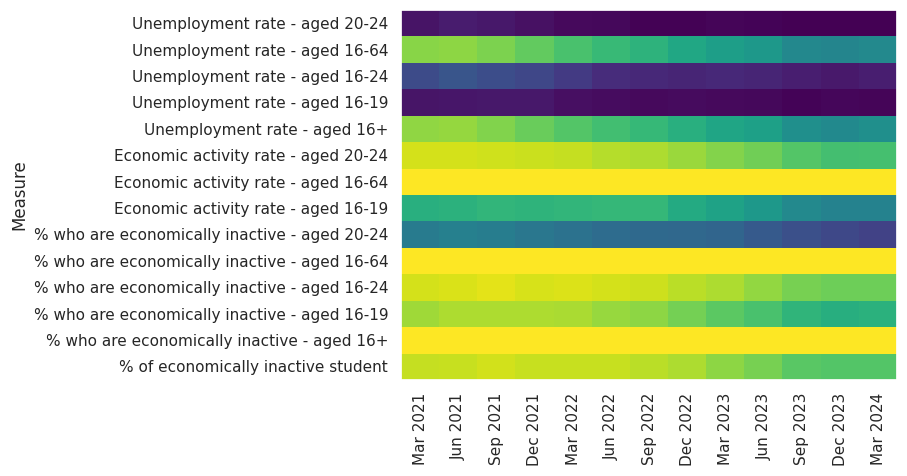

In [6]:
def visualise_coverage(data):
    counts = pd.DataFrame({
      'available': data.groupby(['date', 'variable_name']).value.count(),
      'total': data.groupby(['date', 'variable_name']).value.size()
    })
    coverage = pd.Series(
      counts.available / counts.total, name='coverage'
    ).reset_index().pivot(
      index='variable_name', columns='date', values='coverage'
    )
    plt.imshow(coverage, origin='lower', cmap='viridis', interpolation='nearest', aspect='auto')
    plt.grid(None)
    plt.ylabel('Measure')
    plt.yticks(ticks=range(len(coverage.index)), labels=coverage.index)
    plt.xticks(ticks=range(len(coverage.columns)), labels=coverage.columns.to_series().dt.strftime('%b %Y'), rotation=90, horizontalalignment='center')
    return coverage

frame.pipe(visualise_coverage)

Get the most recently published data per area, to increase coverage

In [7]:
def get_latest_available(data):
  # Calculate dates
  failsafe_date = data.date.min() - pd.Timedelta("1 days")
  latest_date = data.date.max()
  # Subset the input data
  test_data = data.loc[:, ['geography_code', 'date', 'variable_name', 'value']]
  # Construct a failsafe (to be used in the event that there is no data available)
  # This will have the same index as the most recent values, which we use below...
  failsafe_data = test_data.loc[test_data.date == latest_date]
  failsafe_data.loc[:, ['date', 'value']] = (failsafe_date, -1)
  # Concatenate the test and failsafe_data
  test_data = pd.concat([ test_data, failsafe_data ]).sort_values('date', ascending=True)
  # Get the indexes for the non-zero values
  indexes = test_data.dropna(subset='value').groupby(['geography_code', 'variable_name'])['date'].idxmax()
  return data.loc[indexes]

latest_available = frame.pipe(get_latest_available)

In [8]:
latest = frame.loc[frame.date == frame.date.max()].groupby(['variable_name']).value
patched = latest_available.groupby(['variable_name']).value
coverage = pd.DataFrame({
  'latest coverage': latest.count() / latest.size() * 100,
  'patched coverage': patched.count() / patched.size() * 100,
})

coverage

,latest coverage,patched coverage
variable_name,,
% of economically inactive student,72.620905,98.034591
% who are economically inactive - aged 16+,98.595944,98.584906
% who are economically inactive - aged 16-19,63.572543,97.798742
% who are economically inactive - aged 16-24,77.301092,98.349057
% who are economically inactive - aged 16-64,98.283931,98.584906
% who are economically inactive - aged 20-24,20.436817,72.877358
Economic activity rate - aged 16-19,44.539782,90.330189
Economic activity rate - aged 16-64,98.595944,98.584906
Economic activity rate - aged 20-24,69.734789,98.191824


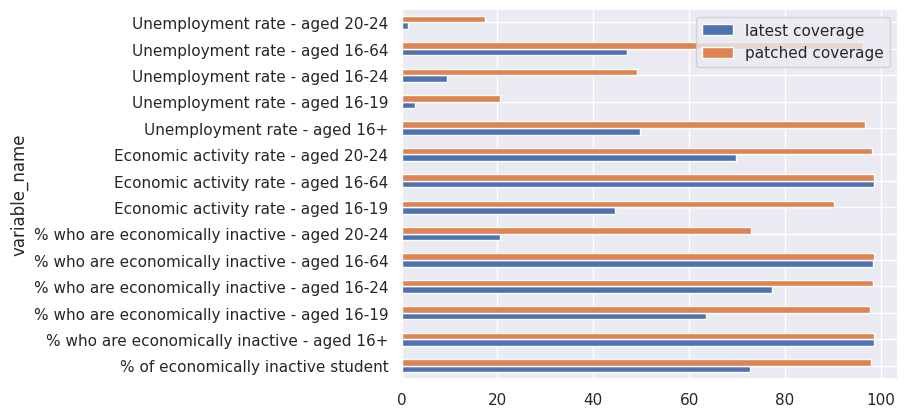

In [9]:
ax = coverage.plot.barh()